In [74]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pandas_bokeh
import finplot as fplt

import polygon_backfill as pb
import market_cluster as mc
import s3_datasets as s3d
import filters as ft
import local_backfill as lb
# import bar_samples as bs
import bar_samples as bs
import bar_labels as bl
import load_ticks as lt

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20, 7]
from matplotlib import style
style.use('fivethirtyeight')

# import ipdb
# ipdb.set_trace(context=10)

symbol='GLD'
date='2020-08-27'
tick_type='trades'
result_path='/Users/bobcolner/QuantClarity/pandas-polygon/data/'

# df.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)  # 'Blues', 'coolwarm', 'RdBu_r' & 'BrBG' are other good diverging colormaps
# pd.set_option('precision', 2)
# get local market daily data
# mdf = pd.read_parquet('data/mdf.parquet')
# sdf = mdf[mdf.symbol=='SPY']

# .plot_bokeh(sizing_mode="scale_height")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load ticks (local or api)
ticks_df = lt.load_ticks(result_path, symbol, date, tick_type, clean=True)

trying to get ticks from local file...
1  duplicated trade removed
dropped 272 ticks ( 0.22 %)


In [3]:
# sample ticks -> bars
renko_size = 0.2
# renko_reversal = 2
thresh = {
    # GT thresholds
    'renko_size': renko_size,
    'renko_reveral_multiple': 2,
    'duration_sec': 60*30,
    'tick_imbalance': 150,
    # LT thresholds 
    'min_duration_sec': 15,
    'min_tick_count': 30,
}
# ticks_df['epoch'] = ticks_df.date_time.astype(int)
tdf = ticks_df[(ticks_df.date_time.dt.hour >= 13) & (ticks_df.date_time.dt.hour <= 22)]
bars, _ = bs.build_bars(ticks_df=tdf, thresh=thresh)
len(bars)

bars_df = pd.DataFrame(bars).set_index('close_at')
# bars_df = pd.DataFrame(bars)

100%|██████████| 123402/123402 [00:01<00:00, 64660.68it/s]


132

In [48]:
bars_df.tick_count.describe()

count     132.00000
mean      934.69697
std       884.94517
min        27.00000
25%       341.25000
50%       679.00000
75%      1214.75000
max      4155.00000
Name: tick_count, dtype: float64

In [45]:
# range / price = HFT profit potential
(tdf.price.max() - tdf.price.min()) / tdf.price.mean()

0.03490524

In [31]:
# label bars
label_horizon_mins = 30
risk_level = 0.2
# reward_base = 1
reward_ratios = np.arange(3, 20, .5)

lbars = bl.label_bars(bars, ticks_df, risk_level, label_horizon_mins, reward_ratios)

lbars_df = pd.DataFrame(lbars)

lbars_unq = bl.get_concurrent_stats(lbars_df)

100%|██████████| 132/132 [00:15<00:00,  8.49it/s]


In [32]:
lbars_df[['price_wmean', 'label_rrr']].plot_bokeh(sizing_mode="scale_height")
# 17, 31

Figure(id='1167', ...)

In [26]:
label_prices, price_end_at = bl.get_label_ticks(tdf, bars[31]['close_at'], 30)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

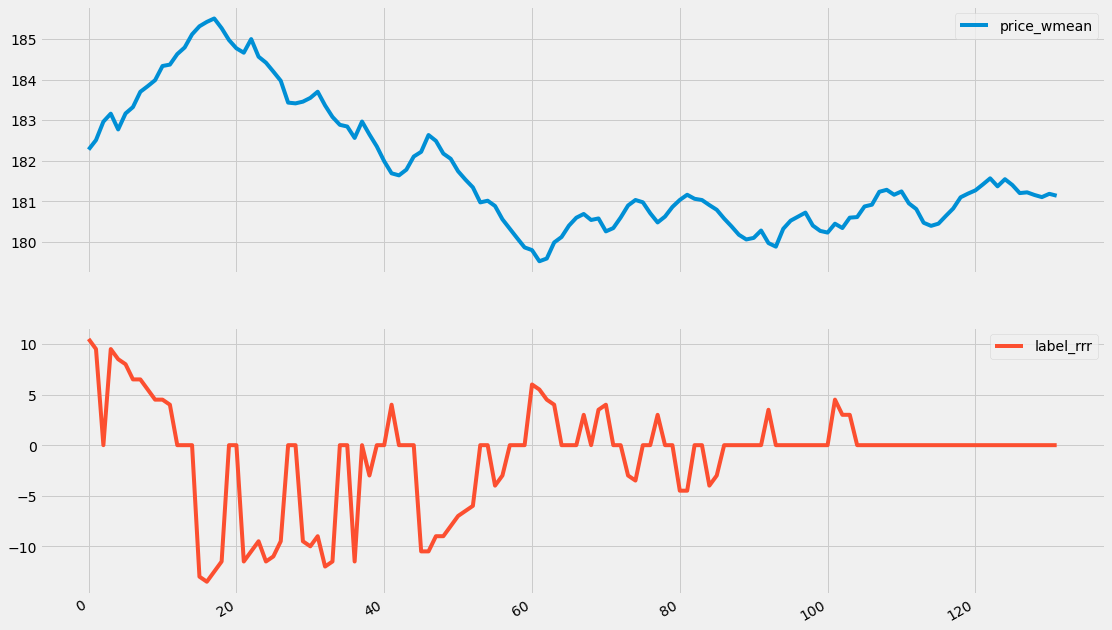

In [33]:
lbars_df[['price_wmean', 'label_rrr']].plot(subplots=True, figsize=[17,12])